# Set up enviroment

In [1]:
!pip install pmdarima
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tokens = ["btc", "eth", "xrp"]
train_test_split = ["721", "622", "811"]

data_source = '/content/drive/My Drive/Report_DBA/final_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

targets = ["Close"]

data_set = {1: "train", 2: "test", 3: "validation"}

model_name = "arima"

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures

# working on
token_id = 2
# n_split = 0 # 721
# n_split = 1 # 622
n_split = 2 # 811

In [4]:
%cd $data_source
# !ls

/content/drive/My Drive/Report_DBA/final_report


In [5]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

# Get raw data

In [6]:
def getData(data_dir = "processing", subset = "train", token_id  = 0):
    df = pd.read_excel(f"{data_dir}/{tokens[token_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx")
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

# Define supervised data

In [7]:
def getSupervisedData(T, TF, train, test, val):

    # TRAIN
    series = train.to_numpy()
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float).reshape(len(Y),)

    # TEST
    series = np.concatenate([train.to_numpy()[-T:],test.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float).reshape(len(Y),)

    # VAL
    series = np.concatenate([test.to_numpy()[-T:],val.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xval = np.array(X).astype(float)
    Yval = np.array(Y).astype(float).reshape(len(Y),)

    return Xtrain,Ytrain, Xtest,Ytest, Xval, Yval

# Build Model

In [8]:
def buildModel(df):
  arimaModel = pm.auto_arima(df,
                      test='adf',       # use adftest to find optimal 'd'
                      trace=True,
                      max_p = 10,
                      max_q = 10,
                      error_action='ignore',
                      suppress_warnings=True,
                      seasonal=False,
                      n_fits = 100,
                      alpha = 0.01,
                      maxiter = 50,
                      stepwise=False,
                             )
  return arimaModel

# Start

In [9]:
df_train = getData(subset="train")
df_test = getData(subset="test")
df_val = getData(subset="validation")

In [10]:
model = buildModel(df_train)
print(model.summary())

model_location = f"Model/{tokens[token_id]}"

# create folder if not exits
os.makedirs(model_location, exist_ok=True)

# save
joblib.dump(model, f"{model_location}/{model_name}_{train_test_split[n_split]}.pkl")

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8690.909, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8689.855, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8687.898, Time=0.80 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8686.166, Time=0.88 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8686.206, Time=2.02 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-8684.305, Time=3.84 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8689.844, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8687.871, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8686.141, Time=2.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8684.063, Time=1.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8684.037, Time=2.73 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8687.912, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8685.909, Time=2.65 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8683.115, Time=4.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8683.278, Time=1.05

['Model/xrp/arima_811.pkl']

# Test and Visualization

In [11]:
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mae = mean_absolute_error(actual, predict)
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df


In [12]:
# load model to predict
model = joblib.load(f"Model/{tokens[token_id]}/{model_name}_{train_test_split[n_split]}.pkl")
model

metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],

    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],

    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict_in_sample()
y_pred_test = model.predict(n_periods=len(df_test))


# # inverse transform TRAIN
pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(1, -1))
y_true_train = scaler.inverse_transform(df_train)

# # inverse transform TEST
pred_test = scaler.inverse_transform(np.array(y_pred_test).reshape(1, -1))
y_true_test = scaler.inverse_transform(df_test)


model.update(df_test)
y_pred_val = model.predict(n_periods=len(df_val))
# # inverse transform VAL
pred_val = scaler.inverse_transform(np.array(y_pred_val).reshape(1, -1))
y_true_val = scaler.inverse_transform(df_val)


metrics_df = evaluate(metrics_df, "train", df_train.Close.values, pred_train.squeeze())
metrics_df = evaluate(metrics_df, "test", df_test.Close.values, pred_test.squeeze())
metrics_df = evaluate(metrics_df, "val", df_val.Close.values, y_true_val.squeeze())

metrics_df = pd.DataFrame(metrics_df)
metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}_{train_test_split[n_split]}.xlsx")
metrics_df



,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,0.955124,0.72147,3.947319e+11,1.796807,1.792203,6.111903,0.843012,0.826836,2.722569


In [13]:
y_true_train

array([[0.52918745],
       [0.53417424],
       [0.5466736 ],
       ...,
       [1.96434661],
       [1.96347231],
       [2.01324306]])

In [14]:
pred_train

array([[0.14055906, 0.53011151, 0.5350983 , ..., 1.97802908, 1.96527067,
        1.96439636]])

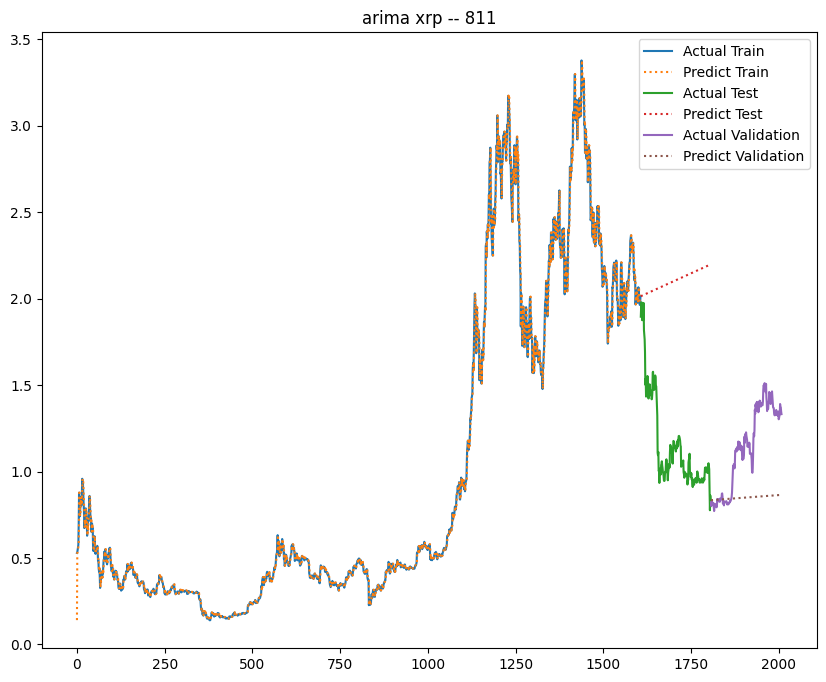

In [15]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(y_true_train.squeeze()))
plt.plot([*train_range], y_true_train.squeeze(), label="Actual Train", color = color_palette[0])
plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(y_true_test.squeeze()))
plt.plot([*test_range], y_true_test.squeeze(), label="Actual Test", color=color_palette[2])
plt.plot([*test_range], pred_test.squeeze(), label="Predict Test", linestyle="dotted", color=color_palette[3])

# val
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_true_val.squeeze()))
plt.plot([*val_range], y_true_val.squeeze(), label="Actual Validation", color=color_palette[4])
plt.plot([*val_range], pred_val.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[5])

plt.legend()
plt.title(f"{model_name} {tokens[token_id]} -- {train_test_split[n_split]}")

save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_{train_test_split[n_split]}.png")
plt.show()